## STMO Project

In [14]:
pip install googlemaps

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for googlemaps: filename=googlemaps-4.10.0-py3-none-any.whl size=40750 sha256=fc471a2cb2fb5d4eb38af34bf97dc89ee93738cb50e23a2520caaa9c1ad69ed7
  Stored in directory: c:\users\fonte\appdata\local\pip\cache\wheels\f1\09\77\3cc2f5659cbc62341b30f806aca2b25e6a26c351daa5b1f49a
Successfully built googlemaps
Note: you may need to restart the kernel to use updated packages.


In [2]:
import random
import time
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import osmnx as ox
import googlemaps

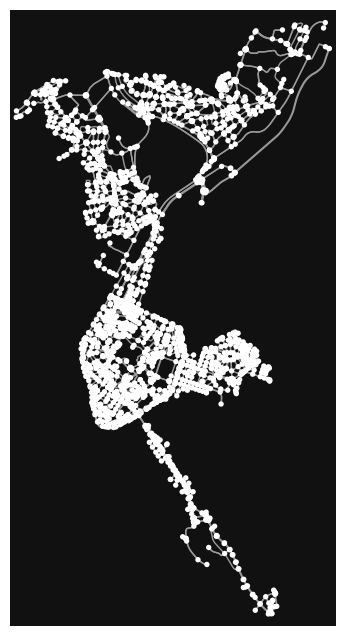

In [3]:
place_name = 'Brussels'
graph = ox.graph_from_place(place_name, network_type='drive')
fig, ax = ox.plot_graph(graph)
plt.show()